# Content based recommender filtering

## Introduction

Content based filtering is constructed with restaurant's metadata and restaurant reviews. It provide a restaurant recommendations to user based on user profile.

## Implementation Strategy

### 1 Ranking
#### 1.1 Cosine Similarity between user - restaurant vectors by using Tfidf Vectorizer
Restaurant feature vector is computed from restaurant review by Tfidf Vectorizer and user feature vector is computed by restaurant feature vector weighted by corresponding user rating.

#### 1.2 Predicted user rating of restaurant
User's rating is predicted using supervised regression model. RMSE is used for model selection. 

### 2. Evaluation using NDCG
`Normalized Discounted Cumulative Gain` is used to evalauate above three ranking strategies. For each policy, NDCG@5 and NDCG@10 are computed. Results proves the startegy I to be consistently best. Strategy I utilizes restaurant review data to calculate vectors and restaurant metadata can be extracted from rich review dataset. 

### 3 Implementation 

#### 3.1 Development
The best performing ranking policy is chosen for implementing content based recommender filtering. User, restaurant feature vector are computed and saved to a file. For the `user_id` of interest, cosine similarly scores are calculated between user and restaurants, added back as a restaurant feature. Then restaurant list is filtered and ranked by descending similarity scores to generate the recommendations.

#### 3.2 Testing
Different test cases are implemented to see the completeness and coputing time

In [1]:
# Import required libraries 

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import dill

import matplotlib.pyplot as plt

import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

In [2]:
# Load business data

business = pd.read_csv('clean_business.csv')
business.head()

,city,attributes.GoodForMeal,attributes.Smoking,attributes.BusinessAcceptsBitcoin,address,attributes.BYOBCorkage,attributes.WheelchairAccessible,attributes.RestaurantsDelivery,state,attributes.OutdoorSeating,...,hours.Tuesday,attributes.BusinessParking,hours.Monday,attributes.CoatCheck,hours,hours.Friday,attributes.BusinessAcceptsCreditCards,attributes.RestaurantsTableService,cuisine,style
0,Champaign,NaN,NaN,NaN,404 E Green St,NaN,NaN,True,IL,False,...,11:30-14:30,None,11:30-14:30,NaN,"{'Monday': '11:30-14:30', 'Tuesday': '11:30-14...",11:30-14:30,True,NaN,"ethnic food,specialty food","food trucks,restaurants"
1,Charlotte,NaN,NaN,NaN,4508 E Independence Blvd,NaN,NaN,NaN,NC,False,...,NaN,"{'garage': False, 'street': False, 'validated'...",NaN,NaN,NaN,NaN,True,NaN,middle eastern,restaurants
2,Mesa,NaN,NaN,NaN,1255 W Main St,NaN,NaN,NaN,AZ,NaN,...,0:0-0:0,"{'garage': False, 'street': False, 'validated'...",0:0-0:0,NaN,"{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W...",0:0-0:0,True,NaN,"donuts,coffee & tea",juice bars & smoothies
3,Phoenix,NaN,NaN,NaN,"4550 East Cactus Rd, #KSFC-4",NaN,NaN,False,AZ,False,...,10:0-21:0,"{'garage': False, 'street': False, 'validated'...",10:0-21:0,NaN,"{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'...",10:0-21:0,True,NaN,bakeries,"fast food,restaurants"
4,Las Vegas,NaN,NaN,NaN,9595 W Tropicana Ave,NaN,NaN,False,NV,False,...,NaN,"{'garage': False, 'street': False, 'validated'...",NaN,NaN,NaN,NaN,True,NaN,mexican,"restaurants,fast food"


In [3]:
# Load review data

review = pd.read_csv('clean_review.csv')
review.head()

,date,review_id,user_id,useful,funny,text,business_id,stars,cool
0,2015-04-15 05:21:16,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,5,0.0,"As someone who has worked with many museums, I...",-MhfebM0QIsKt87iDN-FNw,2.0,0.0
1,2013-12-07 03:16:52,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,1,1.0,I am actually horrified this place is still in...,lbrU8StCq3yDfr-QMnGrmQ,1.0,0.0
2,2015-12-05 03:18:11,LG2ZaYiOgpr2DK_90pYjNw,V34qejxNsCbcgD8C0HVk-Q,1,0.0,I love Deagan's. I do. I really do. The atmosp...,HQl28KMwrEKHqhFrrDqVNQ,5.0,0.0
3,2011-05-27 05:30:52,i6g_oA9Yf9Y31qt0wibXpw,ofKDkJKXSKZXu5xJNGiiBQ,0,0.0,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",5JxlZaqCnk1MnbgRirs40Q,1.0,0.0
4,2017-01-14 21:56:57,6TdNDKywdbjoTkizeMce8A,UgMW8bLE0QMJDCkQ1Ax5Mg,0,0.0,"Oh happy day, finally have a Canes near my cas...",IS4cv902ykd8wj1TR0N3-A,4.0,0.0


#### Subset of `review` dataset containing only related filtered business (US based restaurants)

In [4]:
%%time

# Clean review data based on cleaned business data (US based restaurant businesses)

review_clean = review[review.business_id.isin(business.business_id.unique())].reset_index(drop=True)

print(len(review), len(review_clean))

8021124 4425255
CPU times: user 2.11 s, sys: 188 ms, total: 2.3 s
Wall time: 2.3 s


#### Split dataset

1. `review_clean` dataset is randomly split by 80:20, train-test ratio.
2. Users and businesses that are only present in the test data are moved to the train data.

In [5]:
%%time

# Split review data

train_review_clean, test_review_clean = train_test_split(review_clean, test_size=0.2, random_state=42)

print('Current train-test ratio: ', len(train_review_clean)/len(review_clean))
print('Train dataset: ', len(test_review_clean))

Current train-test ratio:  0.8
Train dataset:  885051
CPU times: user 2.31 s, sys: 76.1 ms, total: 2.38 s
Wall time: 2.38 s


#### One value in text and date (separate rows) contains NaN valus 

In [6]:
mask = train_review_clean.text.apply(lambda x: type(x) == float)
print (train_review_clean[mask])

Empty DataFrame
Columns: [date, review_id, user_id, useful, funny, text, business_id, stars, cool]
Index: []


In [7]:
train_review_clean = train_review_clean.dropna()

#### Move reviews of user that are only present in test data

In [8]:
test_only_user = test_review_clean[~test_review_clean.user_id.isin(train_review_clean.user_id.unique())]

idx_user = test_only_user['user_id'].drop_duplicates().index
idx_train = train_review_clean.index.union(idx_user)
idx_test = review_clean.index.difference(idx_train)

train_review = review_clean.loc[idx_train]
test_review = review_clean.loc[idx_test]

print('Current train-test ratio: ',len(train_review)/len(review_clean))

Current train-test ratio:  0.8342956507591088


#### Move reviews of businesses that are only present in test data

In [9]:
test_only_bus = test_review_clean[~test_review_clean.business_id.isin(train_review_clean.business_id.unique())]

idx_bus = test_only_bus['business_id'].drop_duplicates().index
idx_train = train_review_clean.index.union(idx_bus)
idx_test = review_clean.index.difference(idx_train)

train_review = review_clean.loc[idx_train]
test_review = review_clean.loc[idx_test]

print('Current train-test ratio: ',len(train_review)/len(review_clean))

Current train-test ratio:  0.8000045195135648


In [10]:
# Update `postal_code` column in the business dataset as string

business['postal_code'] = business.postal_code.astype('str')

### 1 Ranking 
#### 1.1 Cosine Similarity between user - restaurant vectors by using Tfidf Vectorizer

#### Append all `business_id` reviews

In [11]:
# Combine reviews for each restaurants

bus_rev = train_review.groupby('business_id').agg\
        ({'review_id' : 'count','text': lambda a: '##'.join(a)}).rename\
        (columns={'review_id' : 'review_count', 'text': 'combined_reviews'})

bus_rev = bus_rev.reset_index()
bus_rev.head()

,business_id,review_count,combined_reviews
0,--9e1ONYQuAa-CB_Rrw7Tw,1439,On yelp 5 stars = Woohoo! as good as it gets! ...
1,--FBCX-N37CMYDfs790Bnw,141,My husband and I live nearby and only stopped ...
2,--FnvijzY20d1nk9H7fk9w,9,Great addition to the area! I heard about this...
3,--GM_ORV2cYS-h38DSaCLw,12,I don't care for their pizza all that much. My...
4,--I7YYLada0tSLkORTHb5Q,95,"Had to get my wing fix, I like dry rubs on win..."


#### Restaurants vector using Tfidf Vectorizer

In [12]:
%%time

# Tfidf to extract top 500 features

vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=500)   ## limit to top 500 words
X = vectorizer.fit_transform(bus_rev.combined_reviews)                                     ## scipy.sparse.csr.csr_matrix 

CPU times: user 11min 39s, sys: 7.82 s, total: 11min 46s
Wall time: 11min 46s


In [13]:
X_df = pd.DataFrame(X.todense())
# X = X.astype(pd.SparseDtype("float", np.nan))

In [14]:
bus_revFeature = X_df.set_index(bus_rev.business_id)
bus_revFeature.columns = vectorizer.get_feature_names()
bus_revFeature.head()

,10,15,20,30,50,able,absolutely,actually,add,ago,...,worst,worth,wouldn,wow,wrong,year,years,yelp,yes,yummy
business_id,,,,,,,,,,,,,,,,,,,,,
--9e1ONYQuAa-CB_Rrw7Tw,0.016727,0.008300,0.013164,0.011615,0.015592,0.018676,0.023129,0.016335,0.008027,0.012796,...,0.004872,0.048930,0.013514,0.018818,0.013005,0.019652,0.023406,0.010828,0.019761,0.014790
--FBCX-N37CMYDfs790Bnw,0.015638,0.014549,0.007101,0.000000,0.024754,0.003909,0.021624,0.013280,0.000000,0.015272,...,0.015182,0.013008,0.007581,0.000000,0.007015,0.019685,0.041030,0.007992,0.011547,0.016268
--FnvijzY20d1nk9H7fk9w,0.000000,0.000000,0.000000,0.033017,0.037632,0.000000,0.000000,0.030283,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062376,0.000000,0.000000,0.000000
--GM_ORV2cYS-h38DSaCLw,0.000000,0.033168,0.032374,0.000000,0.000000,0.035645,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.034563,0.000000,0.063967,0.000000,0.000000,0.000000,0.000000,0.000000
--I7YYLada0tSLkORTHb5Q,0.041161,0.011967,0.011681,0.011909,0.000000,0.025721,0.005929,0.005461,0.026454,0.018842,...,0.000000,0.021399,0.037411,0.006891,0.011540,0.012953,0.005625,0.000000,0.000000,0.006690


#### Feature/ Dimension reduction with PCA

350 features accounts to:  93.97808370180329
CPU times: user 12 s, sys: 3.11 s, total: 15.1 s
Wall time: 2.32 s


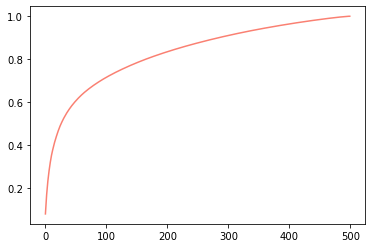

In [15]:
%%time

pca = PCA()
bus_pcaFeature = pca.fit_transform(bus_revFeature)
VR = pca.explained_variance_ratio_

VR_sum = [sum(VR[:i+1]) for i in range(len(VR))]
plt.plot(list(range(len(VR))), VR_sum, color='salmon');
print('350 features accounts to: ', VR_sum[350]*100)

In [16]:
# Keep only top 350 PCA as it contains ~95% of the variations

bus_pcaFeature = pd.DataFrame(bus_pcaFeature[:,:300], columns=[str(i) for i in np.arange(0,300)]).set_index\
               (bus_revFeature.index)
bus_pcaFeature.columns.name = 'principle_components'

bus_pcaFeature.head()

principle_components,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
business_id,,,,,,,,,,,,,,,,,,,,,
--9e1ONYQuAa-CB_Rrw7Tw,-0.156370,-0.108129,0.157396,0.028886,-0.114094,0.098371,-0.102743,0.051139,-0.164267,-0.213155,...,0.007412,-0.000981,-0.008417,-0.017205,-0.008879,0.004590,-0.006430,0.003860,0.005689,0.002580
--FBCX-N37CMYDfs790Bnw,-0.186696,0.054678,0.464437,0.046934,0.091829,-0.050600,0.012284,-0.044021,0.068506,0.147150,...,-0.007280,-0.006785,-0.012477,0.018835,-0.000525,-0.005758,-0.007513,-0.013248,-0.020267,0.004450
--FnvijzY20d1nk9H7fk9w,-0.097000,-0.119259,-0.049686,0.194754,0.097983,0.126405,0.072437,-0.038908,-0.063569,-0.056447,...,0.016132,-0.007923,-0.002689,0.008527,0.037770,-0.005093,-0.001095,-0.008378,-0.029374,0.031144
--GM_ORV2cYS-h38DSaCLw,0.693107,-0.255442,0.020307,-0.008587,0.037326,0.000563,0.032221,0.021250,0.029544,-0.013628,...,0.008405,-0.006519,0.011933,-0.035685,-0.003601,0.015149,-0.019561,-0.002755,0.000569,-0.007065
--I7YYLada0tSLkORTHb5Q,-0.195269,-0.138191,0.348275,-0.075514,0.030333,-0.132355,0.155408,-0.032200,-0.006697,0.015857,...,0.007422,0.026142,0.019767,-0.011210,0.002585,-0.004526,-0.018729,-0.026633,-0.000376,-0.008496


In [17]:
# Refactor the PCA coefficients so that all feature vector has the unit length

bus_pcaFeature['root_sum_sq'] = bus_pcaFeature.apply(lambda row: np.sqrt(sum([i*i for i in row])), axis=1)
bus_pcaFeature = bus_pcaFeature.divide(bus_pcaFeature.root_sum_sq, axis=0).drop('root_sum_sq', axis=1)

bus_pcaFeature.head()

principle_components,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
business_id,,,,,,,,,,,,,,,,,,,,,
--9e1ONYQuAa-CB_Rrw7Tw,-0.215563,-0.149060,0.216977,0.039821,-0.157283,0.135608,-0.141636,0.070497,-0.226448,-0.293842,...,0.010218,-0.001353,-0.011603,-0.023718,-0.012241,0.006328,-0.008863,0.005321,0.007843,0.003557
--FBCX-N37CMYDfs790Bnw,-0.279352,0.081814,0.694934,0.070227,0.137403,-0.075712,0.018381,-0.065868,0.102505,0.220179,...,-0.010892,-0.010153,-0.018670,0.028182,-0.000785,-0.008616,-0.011242,-0.019824,-0.030325,0.006659
--FnvijzY20d1nk9H7fk9w,-0.124511,-0.153083,-0.063778,0.249990,0.125773,0.162256,0.092982,-0.049943,-0.081598,-0.072457,...,0.020707,-0.010170,-0.003452,0.010946,0.048482,-0.006537,-0.001406,-0.010754,-0.037704,0.039977
--GM_ORV2cYS-h38DSaCLw,0.818780,-0.301758,0.023989,-0.010144,0.044093,0.000665,0.038063,0.025103,0.034901,-0.016099,...,0.009929,-0.007701,0.014097,-0.042155,-0.004254,0.017896,-0.023108,-0.003254,0.000672,-0.008346
--I7YYLada0tSLkORTHb5Q,-0.316671,-0.224106,0.564804,-0.122462,0.049191,-0.214642,0.252027,-0.052220,-0.010860,0.025715,...,0.012036,0.042394,0.032057,-0.018180,0.004192,-0.007339,-0.030374,-0.043191,-0.000610,-0.013778


#### User vector based on restaurants vector

In [18]:
%%time

# User prfoile is constructed by computing weighted sum of restaurant vectors for all user rated item with user rating as weights

user_pcaFeature = pd.merge(train_review[['user_id', 'business_id', 'stars']], bus_pcaFeature, how='inner',\
                          left_on='business_id', right_index=True).drop('business_id', axis=1)

user_pcaFeature.head()

CPU times: user 7.35 s, sys: 8.85 s, total: 16.2 s
Wall time: 16.2 s


,user_id,stars,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,V34qejxNsCbcgD8C0HVk-Q,5.0,-0.364827,-0.25642,0.449219,0.016671,0.114253,0.047348,0.154788,0.045596,...,-0.00915,0.009011,-0.033279,0.007291,0.006399,-0.005839,-0.013472,0.00561,0.000886,-0.006764
1681,zFCuveEe6M-ijY1iy23IJg,5.0,-0.364827,-0.25642,0.449219,0.016671,0.114253,0.047348,0.154788,0.045596,...,-0.00915,0.009011,-0.033279,0.007291,0.006399,-0.005839,-0.013472,0.00561,0.000886,-0.006764
3838,4V985R3RG-rv0B7WCPQzeQ,1.0,-0.364827,-0.25642,0.449219,0.016671,0.114253,0.047348,0.154788,0.045596,...,-0.00915,0.009011,-0.033279,0.007291,0.006399,-0.005839,-0.013472,0.00561,0.000886,-0.006764
4580,nFGcoL6wuPQzxsNJVSfGrA,4.0,-0.364827,-0.25642,0.449219,0.016671,0.114253,0.047348,0.154788,0.045596,...,-0.00915,0.009011,-0.033279,0.007291,0.006399,-0.005839,-0.013472,0.00561,0.000886,-0.006764
4794,CJqgUQeWhdgbDyLAFy7xvQ,4.0,-0.364827,-0.25642,0.449219,0.016671,0.114253,0.047348,0.154788,0.045596,...,-0.00915,0.009011,-0.033279,0.007291,0.006399,-0.005839,-0.013472,0.00561,0.000886,-0.006764


In [19]:
# Refactor user PCA by multiplying with stars

user_pcaFeature.iloc[:, 2:302] = user_pcaFeature.iloc[:, 2:302].multiply(user_pcaFeature.stars, axis=0)

user_pcaFeature.head()

,user_id,stars,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,V34qejxNsCbcgD8C0HVk-Q,5.0,-1.824135,-1.282099,2.246096,0.083356,0.571266,0.236738,0.773938,0.227981,...,-0.04575,0.045056,-0.166394,0.036454,0.031997,-0.029194,-0.067362,0.028048,0.004432,-0.033818
1681,zFCuveEe6M-ijY1iy23IJg,5.0,-1.824135,-1.282099,2.246096,0.083356,0.571266,0.236738,0.773938,0.227981,...,-0.04575,0.045056,-0.166394,0.036454,0.031997,-0.029194,-0.067362,0.028048,0.004432,-0.033818
3838,4V985R3RG-rv0B7WCPQzeQ,1.0,-0.364827,-0.256420,0.449219,0.016671,0.114253,0.047348,0.154788,0.045596,...,-0.00915,0.009011,-0.033279,0.007291,0.006399,-0.005839,-0.013472,0.005610,0.000886,-0.006764
4580,nFGcoL6wuPQzxsNJVSfGrA,4.0,-1.459308,-1.025679,1.796876,0.066685,0.457013,0.189390,0.619150,0.182385,...,-0.03660,0.036045,-0.133115,0.029163,0.025598,-0.023355,-0.053889,0.022439,0.003546,-0.027055
4794,CJqgUQeWhdgbDyLAFy7xvQ,4.0,-1.459308,-1.025679,1.796876,0.066685,0.457013,0.189390,0.619150,0.182385,...,-0.03660,0.036045,-0.133115,0.029163,0.025598,-0.023355,-0.053889,0.022439,0.003546,-0.027055


In [20]:
%%time

user_pcaFeature = user_pcaFeature.drop('stars', axis=1).groupby('user_id').sum()

CPU times: user 18.5 s, sys: 6.71 s, total: 25.2 s
Wall time: 25.2 s


In [21]:
# Refactor the PCA coefficients so that all feature vector has the unit length

user_pcaFeature['root_sum_sq'] = user_pcaFeature.apply(lambda row: np.sqrt(sum([i*i for i in row])), axis=1)
user_pcaFeature = user_pcaFeature.drop('root_sum_sq', axis=1).divide(user_pcaFeature.root_sum_sq, axis=0)

user_pcaFeature.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
user_id,,,,,,,,,,,,,,,,,,,,,
---1lKK3aKOuomHnwAkAow,0.131914,-0.367590,0.282893,0.156940,-0.119999,0.371376,-0.104210,0.122812,-0.212711,-0.179484,...,0.002415,-0.000493,-0.006960,-0.000223,-0.011380,0.015422,0.002622,-0.010092,0.007116,0.004880
---89pEy_h9PvHwcHNbpyg,-0.211886,0.152087,0.625090,0.071052,0.160283,-0.139958,-0.000691,-0.092279,0.097859,0.294535,...,0.023323,0.007969,-0.001641,0.005788,0.019128,-0.016993,-0.024073,-0.017096,-0.026375,0.017023
---94vtJ_5o_nikEs6hUjg,-0.217836,-0.087141,0.343381,-0.337582,0.075269,-0.361819,0.381020,0.151826,-0.017666,-0.276623,...,0.002454,-0.013334,0.009887,0.011482,0.003058,0.011421,-0.006156,-0.021435,0.013906,-0.005537
---PLwSf5gKdIoVnyRHgBA,-0.265473,-0.035578,0.395243,-0.217898,0.018276,-0.043327,-0.394252,0.014154,-0.019407,-0.093263,...,-0.037400,-0.029145,-0.005810,0.017516,-0.005564,0.026095,0.028598,-0.006435,-0.003608,0.032920
---RfKzBwQ8t3wu-LXvx3w,0.938897,-0.209044,0.096878,0.024251,0.016652,0.046052,-0.021654,0.006703,0.019095,-0.027661,...,0.002550,0.017854,-0.002392,-0.004618,0.011095,-0.001937,-0.002990,-0.002986,-0.000943,0.001384


#### Save PCA features

In [22]:
%%time

# Business PCA features as pickle file
with open('train_bus_pcaFeature.pkl','wb') as f:
    pickle.dump(bus_pcaFeature, f)
    
# User PCA feature as pickle file
with open('train_user_pcaFeature.pkl','wb') as f:
    pickle.dump(user_pcaFeature, f)
    
    
    
# Free some space
bus_revFeature = None
pca = None
VR = None
VR_sum = None
bus_pcaFeature = None
user_pcaFeature = None

CPU times: user 1.22 s, sys: 3.03 s, total: 4.25 s
Wall time: 26.8 s


#### 1.2 Predicted user rating of resturant

In [23]:
# Feature building

# Numerical columns from business dataset
reg_bus = business[['business_id','latitude','longitude','stars','review_count']]

reg_train = train_review[['review_id','user_id','business_id','stars']].set_index('review_id')
reg_test = test_review[['review_id','user_id','business_id','stars']].set_index('review_id')

# Merge numerical columns from business dataset on `business_id`
reg_train = reg_train.merge(reg_bus, how='inner', on='business_id', suffixes=('_review', '_business'))
reg_test = reg_test.merge(reg_bus, how='inner', on='business_id', suffixes=('_review', '_business'))

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# import regression models and metrics
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.metrics import r2_score, mean_squared_error

In [38]:
# Create a function to display regression model performance

index = ['Lasso','Ridge','Random Forest','Gradient Boosting']
result_table = pd.DataFrame(index = index, columns= ['r2_train','mse_train','rmse_train','r2_test','mse_test','rmse_test'])

def display_reg_results(model, pred_train, pred_test):
    
    r2_train = r2_score(y_train, pred_train)
    r2_test = r2_score(y_test, pred_test)
    mse_train = mean_squared_error(y_train, pred_train)
    mse_test = mean_squared_error(y_test, pred_test)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    
    result_table.loc[model,:] = r2_train, mse_train, rmse_train, r2_test, mse_test, rmse_test

In [39]:
%%time

x_train, y_train = reg_train.drop(['user_id','business_id','stars_review'], axis=1), reg_train.stars_review
x_test, y_test = reg_test.drop(['user_id','business_id','stars_review'], axis=1), reg_test.stars_review

## Lasso model ##

lasso = Pipeline([('scaler', StandardScaler()),('lasso', Lasso(alpha=0.0015, max_iter=1000, selection='random'))])
lasso.fit(x_train, y_train)
pred_train = lasso.predict(x_train)
pred_test = lasso.predict(x_test)

# Features, coefficients 
coeff_feature = pd.DataFrame({'feature':x_train.columns, 'coefficient':lasso.named_steps.lasso.coef_})
print("Feature coefficients for the fitted Lasso model:\n",coeff_feature.sort_values('coefficient',ascending=False))

# logging of model performance
display_reg_results("Lasso", pred_train, pred_test)

## Ridge model ##

ridge = Pipeline([('scaler', StandardScaler()),('ridge',Ridge(alpha=100,max_iter=1000,tol=0.001))])
ridge.fit(x_train, y_train)
pred_train = ridge.predict(x_train)
pred_test = ridge.predict(x_test)

# Features, coefficients
coeff_feature = pd.DataFrame({'feature':x_train.columns, 'coefficient':ridge.named_steps.ridge.coef_})
print("\nFeature coefficients for the fitted Ridge model:\n", coeff_feature.sort_values('coefficient',ascending=False))

# logging of model performance
display_reg_results("Ridge", pred_train, pred_test)

## Rnadom forest model ##

rfr = Pipeline([('scaler', StandardScaler()),('rfr', RandomForestRegressor(n_estimators=70, max_features='log2'))])
rfr.fit(x_train, y_train)
pred_train = rfr.predict(x_train)
pred_test = rfr.predict(x_test)

# Features, importance
rank_feature = pd.DataFrame({'feature': x_train.columns, 'importance': rfr.named_steps.rfr.feature_importances_})
print("\nFeature importance for the fitted Random Forest Regressor model:\n", rank_feature.sort_values(by='importance',ascending=False))

# logging of model performance
display_reg_results("Random Forest", pred_train, pred_test)

## Gradient boosting model ##

gbr = Pipeline([('scaler', StandardScaler()),('gbr', GradientBoostingRegressor(n_estimators=700, max_features='auto'))])
gbr.fit(x_train, y_train)
pred_train = gbr.predict(x_train)
pred_test = gbr.predict(x_test)

# Features, importance
rank_feature = pd.DataFrame({'feature': x_train.columns, 'importance': gbr.named_steps.gbr.feature_importances_})
print("\nFeature importance for the fitted Gradient Boosting Regressor model:\n", rank_feature.sort_values(by='importance',ascending=False))

# logging of model performance
display_reg_results("Gradient Boosting", pred_train, pred_test)

result_table

Feature coefficients for the fitted Lasso model:
           feature  coefficient
2  stars_business     0.592878
0        latitude    -0.000000
3    review_count     0.000000
1       longitude    -0.000580

Feature coefficients for the fitted Ridge model:
           feature  coefficient
2  stars_business     0.594307
0        latitude     0.000067
3    review_count    -0.000250
1       longitude    -0.002095

Feature importance for the fitted Random Forest Regressor model:
           feature  importance
2  stars_business    0.847817
3    review_count    0.064803
1       longitude    0.045090
0        latitude    0.042290

Feature importance for the fitted Gradient Boosting Regressor model:
           feature  importance
2  stars_business    0.987945
3    review_count    0.005547
1       longitude    0.003372
0        latitude    0.003136
CPU times: user 26min 4s, sys: 10.6 s, total: 26min 15s
Wall time: 26min 11s


,r2_train,mse_train,rmse_train,r2_test,mse_test,rmse_test
Lasso,0.176479,1.648755,1.284039,0.17594,1.649607,1.28437
Ridge,0.176481,1.648751,1.284037,0.175936,1.649616,1.284374
Random Forest,0.18827,1.625147,1.274813,0.164984,1.671539,1.29288
Gradient Boosting,0.178965,1.643777,1.282099,0.177885,1.645713,1.282854


## Evaluation

In [ ]:
def DCG(r, k):
    r = np.asfarray(r)[:min(len(r), k)]
    
    if r.size:
        return np.sum(r / np.log2(np.arange(2, r.size + 2)))
    return None

def NDCG(r, k):
    
    idcg = DCG(sorted(r, reverse=True), k)
    dcg = DCG(r, k)
    
    if idcg == None or dcg == None:
        return None
    return (dcg/idcg)
    

In [40]:
from sklearn.metrics.pairwise import linear_kernel

In [44]:
with open('train_bus_pcaFeature.pkl','rb') as f:
    bus_pcaFeature = pickle.load(f)

In [48]:
with open('train_user_pcaFeature.pkl','rb') as f:
    user_pcaFeature = pickle.load(f)

In [52]:
bus_pcaFeature.head()


principle_components,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
business_id,,,,,,,,,,,,,,,,,,,,,
--9e1ONYQuAa-CB_Rrw7Tw,-0.215563,-0.149060,0.216977,0.039821,-0.157283,0.135608,-0.141636,0.070497,-0.226448,-0.293842,...,0.010218,-0.001353,-0.011603,-0.023718,-0.012241,0.006328,-0.008863,0.005321,0.007843,0.003557
--FBCX-N37CMYDfs790Bnw,-0.279352,0.081814,0.694934,0.070227,0.137403,-0.075712,0.018381,-0.065868,0.102505,0.220179,...,-0.010892,-0.010153,-0.018670,0.028182,-0.000785,-0.008616,-0.011242,-0.019824,-0.030325,0.006659
--FnvijzY20d1nk9H7fk9w,-0.124511,-0.153083,-0.063778,0.249990,0.125773,0.162256,0.092982,-0.049943,-0.081598,-0.072457,...,0.020707,-0.010170,-0.003452,0.010946,0.048482,-0.006537,-0.001406,-0.010754,-0.037704,0.039977
--GM_ORV2cYS-h38DSaCLw,0.818780,-0.301758,0.023989,-0.010144,0.044093,0.000665,0.038063,0.025103,0.034901,-0.016099,...,0.009929,-0.007701,0.014097,-0.042155,-0.004254,0.017896,-0.023108,-0.003254,0.000672,-0.008346
--I7YYLada0tSLkORTHb5Q,-0.316671,-0.224106,0.564804,-0.122462,0.049191,-0.214642,0.252027,-0.052220,-0.010860,0.025715,...,0.012036,0.042394,0.032057,-0.018180,0.004192,-0.007339,-0.030374,-0.043191,-0.000610,-0.013778


In [51]:
user_pcaFeature.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
user_id,,,,,,,,,,,,,,,,,,,,,
---1lKK3aKOuomHnwAkAow,0.131914,-0.367590,0.282893,0.156940,-0.119999,0.371376,-0.104210,0.122812,-0.212711,-0.179484,...,0.002415,-0.000493,-0.006960,-0.000223,-0.011380,0.015422,0.002622,-0.010092,0.007116,0.004880
---89pEy_h9PvHwcHNbpyg,-0.211886,0.152087,0.625090,0.071052,0.160283,-0.139958,-0.000691,-0.092279,0.097859,0.294535,...,0.023323,0.007969,-0.001641,0.005788,0.019128,-0.016993,-0.024073,-0.017096,-0.026375,0.017023
---94vtJ_5o_nikEs6hUjg,-0.217836,-0.087141,0.343381,-0.337582,0.075269,-0.361819,0.381020,0.151826,-0.017666,-0.276623,...,0.002454,-0.013334,0.009887,0.011482,0.003058,0.011421,-0.006156,-0.021435,0.013906,-0.005537
---PLwSf5gKdIoVnyRHgBA,-0.265473,-0.035578,0.395243,-0.217898,0.018276,-0.043327,-0.394252,0.014154,-0.019407,-0.093263,...,-0.037400,-0.029145,-0.005810,0.017516,-0.005564,0.026095,0.028598,-0.006435,-0.003608,0.032920
---RfKzBwQ8t3wu-LXvx3w,0.938897,-0.209044,0.096878,0.024251,0.016652,0.046052,-0.021654,0.006703,0.019095,-0.027661,...,0.002550,0.017854,-0.002392,-0.004618,0.011095,-0.001937,-0.002990,-0.002986,-0.000943,0.001384


In [54]:
review_clean.head()

,date,review_id,user_id,useful,funny,text,business_id,stars,cool
0,2015-12-05 03:18:11,LG2ZaYiOgpr2DK_90pYjNw,V34qejxNsCbcgD8C0HVk-Q,1,0.0,I love Deagan's. I do. I really do. The atmosp...,HQl28KMwrEKHqhFrrDqVNQ,5.0,0.0
1,2011-05-27 05:30:52,i6g_oA9Yf9Y31qt0wibXpw,ofKDkJKXSKZXu5xJNGiiBQ,0,0.0,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",5JxlZaqCnk1MnbgRirs40Q,1.0,0.0
2,2017-01-14 21:56:57,6TdNDKywdbjoTkizeMce8A,UgMW8bLE0QMJDCkQ1Ax5Mg,0,0.0,"Oh happy day, finally have a Canes near my cas...",IS4cv902ykd8wj1TR0N3-A,4.0,0.0
3,2013-05-07 07:25:25,L2O_INwlrRuoX05KSjc4eg,5vD2kmE25YBrbayKhykNxQ,2,0.0,This is definitely my favorite fast food sub s...,nlxHRv1zXGT0c0K51q3jDg,5.0,0.0
4,2015-11-05 23:11:05,ZayJ1zWyWgY9S_TRLT_y9Q,aq_ZxGHiri48TUXJlpRkCQ,1,0.0,"Really good place with simple decor, amazing f...",Pthe4qk5xh4n-ef-9bvMSg,5.0,0.0


In [58]:
test_1 = bus_pcaFeature.iloc[0:5,]

In [61]:
test_2 = user_pcaFeature.iloc[0:5,]

In [68]:
test_3 = test_2.transpose()

In [71]:
test_3

user_id,---1lKK3aKOuomHnwAkAow,---89pEy_h9PvHwcHNbpyg,---94vtJ_5o_nikEs6hUjg,---PLwSf5gKdIoVnyRHgBA,---RfKzBwQ8t3wu-LXvx3w
0,0.131914,-0.211886,-0.217836,-0.265473,0.938897
1,-0.367590,0.152087,-0.087141,-0.035578,-0.209044
2,0.282893,0.625090,0.343381,0.395243,0.096878
3,0.156940,0.071052,-0.337582,-0.217898,0.024251
4,-0.119999,0.160283,0.075269,0.018276,0.016652
...,...,...,...,...,...
295,0.015422,-0.016993,0.011421,0.026095,-0.001937
296,0.002622,-0.024073,-0.006156,0.028598,-0.002990
297,-0.010092,-0.017096,-0.021435,-0.006435,-0.002986
298,0.007116,-0.026375,0.013906,-0.003608,-0.000943


In [75]:
test_1

principle_components,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
business_id,,,,,,,,,,,,,,,,,,,,,
--9e1ONYQuAa-CB_Rrw7Tw,-0.215563,-0.149060,0.216977,0.039821,-0.157283,0.135608,-0.141636,0.070497,-0.226448,-0.293842,...,0.010218,-0.001353,-0.011603,-0.023718,-0.012241,0.006328,-0.008863,0.005321,0.007843,0.003557
--FBCX-N37CMYDfs790Bnw,-0.279352,0.081814,0.694934,0.070227,0.137403,-0.075712,0.018381,-0.065868,0.102505,0.220179,...,-0.010892,-0.010153,-0.018670,0.028182,-0.000785,-0.008616,-0.011242,-0.019824,-0.030325,0.006659
--FnvijzY20d1nk9H7fk9w,-0.124511,-0.153083,-0.063778,0.249990,0.125773,0.162256,0.092982,-0.049943,-0.081598,-0.072457,...,0.020707,-0.010170,-0.003452,0.010946,0.048482,-0.006537,-0.001406,-0.010754,-0.037704,0.039977
--GM_ORV2cYS-h38DSaCLw,0.818780,-0.301758,0.023989,-0.010144,0.044093,0.000665,0.038063,0.025103,0.034901,-0.016099,...,0.009929,-0.007701,0.014097,-0.042155,-0.004254,0.017896,-0.023108,-0.003254,0.000672,-0.008346
--I7YYLada0tSLkORTHb5Q,-0.316671,-0.224106,0.564804,-0.122462,0.049191,-0.214642,0.252027,-0.052220,-0.010860,0.025715,...,0.012036,0.042394,0.032057,-0.018180,0.004192,-0.007339,-0.030374,-0.043191,-0.000610,-0.013778


In [76]:
test_1.business_id

AttributeError: 'DataFrame' object has no attribute 'business_id'

In [70]:
test_1.dot(test_3)

user_id,---1lKK3aKOuomHnwAkAow,---89pEy_h9PvHwcHNbpyg,---94vtJ_5o_nikEs6hUjg,---PLwSf5gKdIoVnyRHgBA,---RfKzBwQ8t3wu-LXvx3w
business_id,,,,,
--9e1ONYQuAa-CB_Rrw7Tw,0.444169,-0.033274,0.032832,0.184008,-0.100751
--FBCX-N37CMYDfs790Bnw,0.034438,0.911478,0.219553,0.312760,-0.196288
--FnvijzY20d1nk9H7fk9w,0.070952,-0.059661,-0.051832,-0.142187,-0.097193
--GM_ORV2cYS-h38DSaCLw,0.185437,-0.160060,-0.122983,-0.214255,0.849856
--I7YYLada0tSLkORTHb5Q,-0.004634,0.394589,0.494480,0.215521,-0.225140


In [74]:
for i in range(len(review_clean)):
    x = review_clean.user_id[i]
    y = review_clean.business_id[i]
    print(x)
    print(y)

V34qejxNsCbcgD8C0HVk-Q
HQl28KMwrEKHqhFrrDqVNQ


In [84]:
a = pd.DataFrame([['shweta', 'curry_theroy']], columns=['u_id', 'b_id'])
a

,u_id,b_id
0,shweta,curry_theroy


In [92]:
bus_p = pd.DataFrame([[0.23, 0.34, 0.33, 0.4, 0.22],[np.NaN, np.NaN, np.NaN, np.NaN, np.NaN]], columns=[1, 2, 3, 4, 5], index=['curry_theroy', 'abc'])
bus_p

,1,2,3,4,5
curry_theroy,0.23,0.34,0.33,0.4,0.22
abc,NaN,NaN,NaN,NaN,NaN


In [88]:
user_p = pd.DataFrame([[.2, .4, .1, .6, .12]], columns=[1, 2, 3, 4, 5], index=['shweta'])
user_p

,1,2,3,4,5
shweta,0.2,0.4,0.1,0.6,0.12


In [101]:
for i in range(len(review_clean)):
    x = review_clean.user_id[i]
    y = review_clean.business_id[i]
    m = user_pcaFeature.loc[x]
    n = bus_pcaFeature.loc[y]
    
    review_clean['cosine_score'] = m.dot(n)
    

KeyError: '4xIRICDNx33zPG-CYshTXQ'

In [100]:
m.dot(n)

0.48140000000000005